# Previsão de Séries Temporais no Google Colab: Prophet e LSTM

Este notebook implementa uma pipeline completa, pronta para uso no Google Colab, para previsão de uma série temporal utilizando dois abordagens complementares:
- Um modelo clássico baseado em decomposição/curvas de crescimento (Prophet)
- Um modelo de deep learning recorrente (LSTM)

A pipeline inclui: importação do dataset em CSV via Pandas, pré-processamento, divisão temporal entre treino e teste, treinamento/avaliação dos modelos, comparação via métricas e visualizações, além de uma justificativa acadêmica para a métrica escolhida.

## Dataset selecionado (Kaggle)
Usaremos a série diária de temperatura mínima em Melbourne (Austrália), disponível no Kaggle:

- Kaggle: [Daily Minimum Temperatures in Melbourne](https://www.kaggle.com/datasets/vipullrathod/daily-min-temperatures/data)
- Arquivo principal: `daily-min-temperatures.csv` (colunas: `Date`, `Temp`)

Assuma que você baixou localmente o arquivo CSV do Kaggle. No Colab, você poderá:
- Fazer upload do arquivo via seletor de arquivos; ou
- Montar o Google Drive e apontar um caminho de arquivo.

> Observação: a pipeline abaixo cuida apenas da importação do CSV via Pandas (sem automação de download do Kaggle), conforme solicitado.

## Estrutura do notebook
1. Preparação do ambiente (instalações e imports)
2. Carregamento do CSV e pré-processamento
3. Divisão temporal de treino e teste
4. Modelo 1: Prophet (ajuste e avaliação)
5. Modelo 2: LSTM (ajuste e avaliação)
6. Comparação de métricas e gráficos
7. Justificativa acadêmica da métrica de comparação e conclusão


## 1. Preparação do ambiente

Esta seção instala e importa as bibliotecas necessárias. No Google Colab, as instalações são transitórias por sessão.

Pacotes usados:
- `pandas`, `numpy`, `matplotlib`, `seaborn`
- `prophet` (ou `cmdstanpy` como backend de instalação se necessário)
- `sktime` (opcional, para comparação com modelos clássicos)
- `scikit-learn` (métricas e escalonamento)
- `tensorflow`/`keras` (modelo LSTM)


In [19]:
!pip install -q prophet pandas numpy matplotlib seaborn scikit-learn tensorflow
!pip install -q sktime

In [20]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import drive
drive.mount('/content/drive', True)

Mounted at /content/drive


## 2. Carregamento do CSV e pré-processamento

Nesta etapa:
- Lemos o arquivo CSV baixado do Kaggle usando Pandas.
- Fazemos parsing de datas, ordenação temporal e checagens básicas.
- Visualizamos rapidamente a série.

Substitua `CSV_PATH` pelo caminho do seu arquivo (upload local no Colab ou caminho no Drive).


        Date  Temp
0 1981-01-01  20.7
1 1981-01-02  17.9
2 1981-01-03  18.8
3 1981-01-04  14.6
4 1981-01-05  15.8
                      Date         Temp
count                 3650  3650.000000
mean   1985-12-31 07:12:00    11.177753
min    1981-01-01 00:00:00     0.000000
25%    1983-07-02 06:00:00     8.300000
50%    1985-12-31 12:00:00    11.000000
75%    1988-06-30 18:00:00    14.000000
max    1990-12-31 00:00:00    26.300000
std                    NaN     4.071837


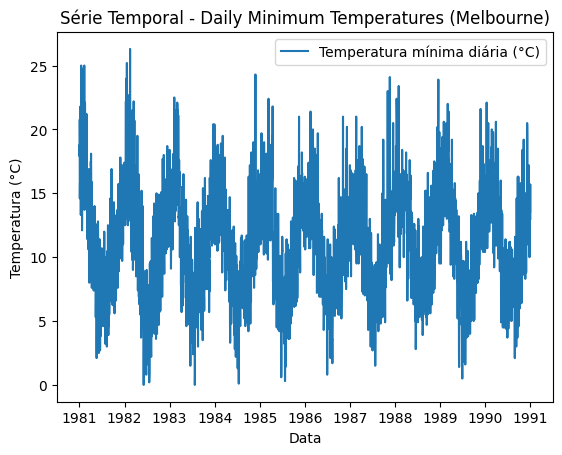

In [21]:
# Defina o caminho para o CSV aqui
CSV_PATH = '/content/drive/MyDrive/daily-min-temperatures.csv'

# Carrega CSV
df = pd.read_csv(CSV_PATH)

# Renomeia colunas se necessário (dataset do Kaggle tem 'Date' e 'Temp')
expected_cols = set(df.columns.str.lower())
if 'date' not in expected_cols or 'temp' not in expected_cols:
    # Tenta normalizar nomes comuns
    df.columns = [c.strip().title() for c in df.columns]

# Converte tipos e ordena por data
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)
else:
    raise ValueError("Coluna 'Date' não encontrada no CSV. Ajuste o nome das colunas conforme o dataset.")

if 'Temp' not in df.columns:
    # tente inferir a coluna numérica da série
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(num_cols) == 1:
        df = df.rename(columns={num_cols[0]: 'Temp'})
    else:
        raise ValueError("Coluna 'Temp' não encontrada. Ajuste para corresponder ao seu CSV.")

print(df.head())
print(df.describe())

# Plot da série
plt.figure()
plt.plot(df['Date'], df['Temp'], label='Temperatura mínima diária (°C)')
plt.title('Série Temporal - Daily Minimum Temperatures (Melbourne)')
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.show()


## 3. Divisão temporal de treino e teste

- Usaremos uma divisão temporal simples (holdout) mantendo a ordem cronológica.
- Defina a fração de teste (por exemplo, 20%).
- Em seguida, reorganizamos o dataframe em formatos apropriados para cada modelo.


Tamanho treino: 2920, teste: 730
Período treino: 1981-01-01 a 1988-12-30
Período teste: 1989-01-01 a 1990-12-31


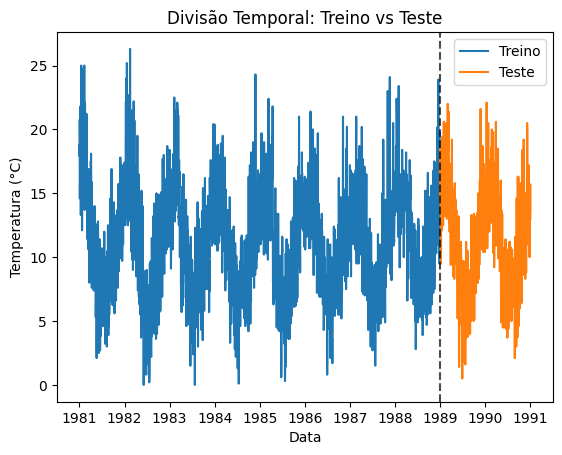

In [22]:
# Tamanho do conjunto de teste (20%)
test_fraction = 0.2
n = len(df)
split_idx = int(n * (1 - test_fraction))

train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

print(f"Tamanho treino: {len(train_df)}, teste: {len(test_df)}")
print(f"Período treino: {train_df['Date'].min().date()} a {train_df['Date'].max().date()}")
print(f"Período teste: {test_df['Date'].min().date()} a {test_df['Date'].max().date()}")

# Visualização da divisão
plt.figure()
plt.plot(train_df['Date'], train_df['Temp'], label='Treino')
plt.plot(test_df['Date'], test_df['Temp'], label='Teste')
plt.axvline(train_df['Date'].max(), color='k', linestyle='--', alpha=0.7)
plt.title('Divisão Temporal: Treino vs Teste')
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.show()


## 4. Modelo 1: Prophet (ajuste e avaliação)

O Prophet modela tendências aditivas com possíveis sazonalidades e feriados. Para este dataset diário, usaremos sazonalidade anual habilitada por padrão. Ajustaremos no conjunto de treino e preveremos exatamente o horizonte do conjunto de teste.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpl6dbtnf1/xt8lhacv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl6dbtnf1/4ysz1u9o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49727', 'data', 'file=/tmp/tmpl6dbtnf1/xt8lhacv.json', 'init=/tmp/tmpl6dbtnf1/4ysz1u9o.json', 'output', 'file=/tmp/tmpl6dbtnf1/prophet_modelb6wgf1pg/prophet_model-20251005215821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:58:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:58:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet - MAE: 2.358 | RMSE: 8.429


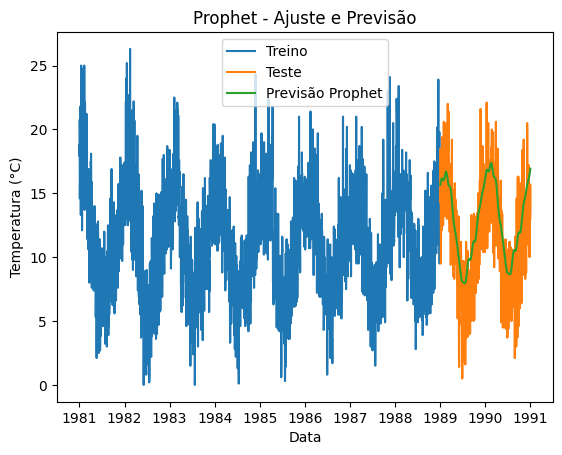

In [23]:
# Prepara dados no formato Prophet: colunas 'ds' (data) e 'y' (valor)
train_prophet = train_df.rename(columns={'Date': 'ds', 'Temp': 'y'})[['ds', 'y']]
test_prophet = test_df.rename(columns={'Date': 'ds', 'Temp': 'y'})[['ds', 'y']]

m = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True)
m.fit(train_prophet)

# Horizonte = tamanho do conjunto de teste
future = m.make_future_dataframe(periods=len(test_prophet), freq='D')
forecast = m.predict(future)

# Seleciona somente a parte correspondente ao horizonte de teste
fcst_test = forecast.tail(len(test_prophet)).copy()

# Métricas Prophet
y_true = test_prophet['y'].values
y_pred_prophet = fcst_test['yhat'].values

mae_prophet = mean_absolute_error(y_true, y_pred_prophet)
rmse_prophet = mean_squared_error(y_true, y_pred_prophet)

print(f"Prophet - MAE: {mae_prophet:.3f} | RMSE: {rmse_prophet:.3f}")

# Plot
plt.figure()
plt.plot(train_df['Date'], train_df['Temp'], label='Treino')
plt.plot(test_df['Date'], test_df['Temp'], label='Teste')
plt.plot(test_df['Date'], y_pred_prophet, label='Previsão Prophet')
plt.title('Prophet - Ajuste e Previsão')
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.show()

## 5. Modelo 2: LSTM (ajuste e avaliação)

Usaremos uma rede recorrente LSTM para prever o próximo valor da série usando janelas deslizantes de tamanho fixo. O pipeline inclui:
- Escalonamento Min-Max no intervalo [0, 1] (apenas com dados de treino)
- Criação de janelas supervisionadas (lookback)
- Modelo Keras com camadas LSTM e Dense
- Treinamento no treino e previsão no conjunto de teste


LSTM - MAE: 1.722 | RMSE: 4.762


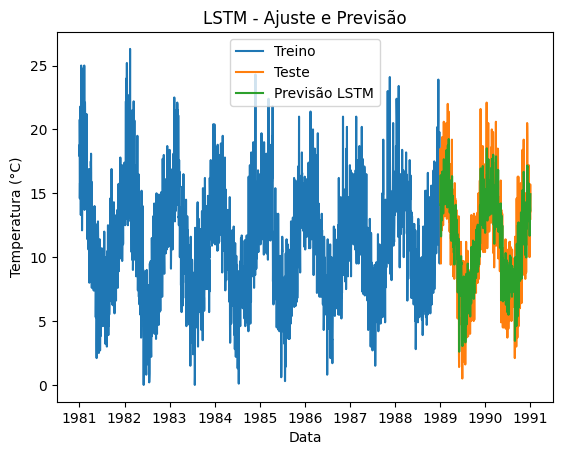

In [24]:
def make_supervised(series: np.ndarray, lookback: int = 14):
    X, y = [], []
    for i in range(len(series) - lookback):
        X.append(series[i:i+lookback])
        y.append(series[i+lookback])
    X = np.array(X)
    y = np.array(y)
    return X[..., np.newaxis], y  # adiciona dimensão de feature

# Escalonamento apenas com dados de treino
scaler = MinMaxScaler()
train_values = train_df['Temp'].values.reshape(-1, 1)
test_values = test_df['Temp'].values.reshape(-1, 1)

train_scaled = scaler.fit_transform(train_values)
test_scaled = scaler.transform(test_values)

lookback = 14  # duas semanas
X_train, y_train = make_supervised(train_scaled.flatten(), lookback)

# Para previsão no horizonte de teste, geramos sequências de forma recursiva
# Estratégia: Começar com a última janela do treino e adicionar as observações reais do teste
# para gerar as próximas previsões (avaliação walk-forward com ground truth)

def build_lstm_model(lookback: int) -> keras.Model:
    model = keras.Sequential([
        layers.Input(shape=(lookback, 1)),
        layers.LSTM(64, return_sequences=False),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='mse')
    return model

lstm_model = build_lstm_model(lookback)
history = lstm_model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,
    verbose=0,
    callbacks=[keras.callbacks.EarlyStopping(patience=25, restore_best_weights=True)]
)

# Previsão no conjunto de teste usando walk-forward com ground truth
y_pred_lstm_scaled = []
# Start with the last 'lookback' values from the training set to form the initial window
current_window = train_scaled.flatten()[-lookback:].tolist()

for t in range(len(test_scaled)):
    # Use the current window to predict the next value
    x_in = np.array(current_window[-lookback:])[np.newaxis, ..., np.newaxis]
    yhat_scaled = lstm_model.predict(x_in, verbose=0)[0, 0]
    y_pred_lstm_scaled.append(yhat_scaled)

    # Update the window with the actual value from the test set
    current_window.append(test_scaled.flatten()[t])


# Inverte escala
y_pred_lstm = scaler.inverse_transform(np.array(y_pred_lstm_scaled).reshape(-1, 1)).flatten()

# Métricas LSTM
y_true_lstm = test_df['Temp'].values
mae_lstm = mean_absolute_error(y_true_lstm, y_pred_lstm)
rmse_lstm = mean_squared_error(y_true_lstm, y_pred_lstm)

print(f"LSTM - MAE: {mae_lstm:.3f} | RMSE: {rmse_lstm:.3f}")

# Plot
plt.figure()
plt.plot(train_df['Date'], train_df['Temp'], label='Treino')
plt.plot(test_df['Date'], test_df['Temp'], label='Teste')
plt.plot(test_df['Date'], y_pred_lstm, label='Previsão LSTM')
plt.title('LSTM - Ajuste e Previsão')
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.show()

## 6. Comparação de métricas e gráficos

Compararemos os modelos via MAE e RMSE no mesmo horizonte de teste. Abaixo consolidamos resultados e visualizações lado a lado quando disponíveis.


              MAE      RMSE
Prophet  2.358307  8.428696
LSTM     1.722330  4.761912


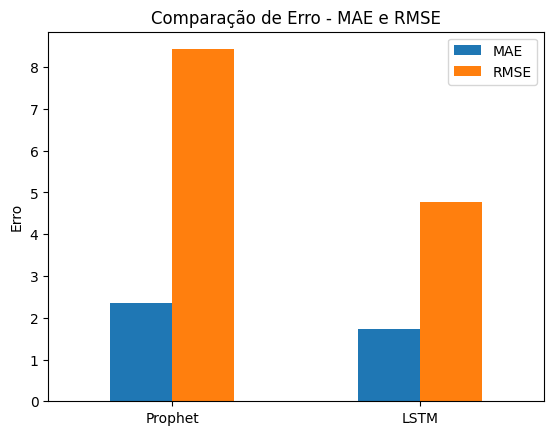

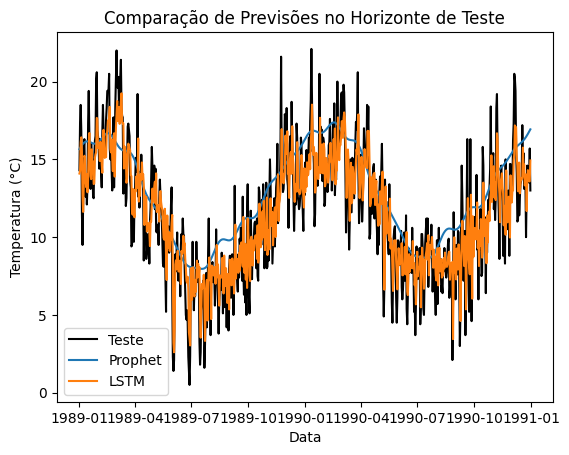

In [25]:
results = {}
results['Prophet'] = {
    'MAE': float(mae_prophet),
    'RMSE': float(rmse_prophet)
}

# LSTM sempre calculado acima
results['LSTM'] = {
    'MAE': float(mae_lstm),
    'RMSE': float(rmse_lstm)
}

res_df = pd.DataFrame(results).T
print(res_df)

# Barra comparativa
res_df.plot(kind='bar')
plt.title('Comparação de Erro - MAE e RMSE')
plt.ylabel('Erro')
plt.xticks(rotation=0)
plt.show()

# Plot conjunto - Prophet vs LSTM (se disponível)
plt.figure()
plt.plot(test_df['Date'], test_df['Temp'], label='Teste', color='black')
plt.plot(test_df['Date'], y_pred_prophet, label='Prophet')
plt.plot(test_df['Date'], y_pred_lstm, label='LSTM')
plt.title('Comparação de Previsões no Horizonte de Teste')
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.show()


## 7. Métrica escolhida e justificativa acadêmica

Neste notebook utilizamos o Erro Absoluto Médio (MAE) e a Raiz do Erro Quadrático Médio (RMSE). Entre essas, destacamos o **RMSE** como métrica principal de comparação por ser sensível a erros maiores (penaliza mais grandes desvios), o que é desejável em cenários onde picos de erro têm maior custo.

- Referência clássica: Hyndman, R.J. & Koehler, A.B. (2006). Another look at measures of forecast accuracy. International Journal of Forecasting, 22(4), 679–688. Disponível em: https://www.sciencedirect.com/science/article/pii/S0169207006000239

De acordo com Hyndman & Koehler (2006), o RMSE é apropriado quando se deseja penalizar mais severamente grandes erros, enquanto o MAE mede o erro médio de forma linear e é mais robusto a outliers. Ao reportarmos ambas as métricas, fornecemos uma visão mais ampla do desempenho dos modelos, mas priorizamos RMSE para capturar a gravidade dos desvios maiores no horizonte de previsão.

**Valores Possíveis e Esperados para MAE e RMSE:**

MAE e RMSE são métricas de erro, portanto, seus valores são sempre não negativos. Um valor de 0 para MAE ou RMSE indica um ajuste perfeito do modelo aos dados, o que é extremamente raro em séries temporais reais devido à aleatoriedade inerente.

Os valores esperados para MAE e RMSE dependem muito da escala da série temporal e da complexidade do padrão a ser previsto. Em geral:

- **Valores menores** para MAE e RMSE indicam um melhor desempenho do modelo (menor erro de previsão).
- As métricas são na **mesma unidade** da série temporal. Por exemplo, se a série é em graus Celsius, o MAE e o RMSE também serão em graus Celsius.
- O **RMSE é sempre maior ou igual ao MAE**. A diferença entre RMSE e MAE aumenta à medida que a variância dos erros aumenta. Isso significa que o RMSE penaliza mais os erros grandes do que o MAE.